## Introduction to our problem

   BookRent is the largest online and offline book rental chain in India. TheCompany charges a fixed fee per month plus rental per book. So, the company makes more money when user rent more books. 


**Objective:**

You as an ML expert have to model recommendation engine so that user gets recommendation of books based on the behavior of similar users. This will ensure that users are renting books based on their individual taste.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing

#Visualisation frameworks
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns

#Model building
from sklearn import preprocessing
from sklearn.cluster import KMeans


## Data Loading

Let's load our data an join it to a single df.

In [2]:
books = pd.read_csv('C:/Users/gabri/Desktop/Data Science/Python/Python for Data Science - Edureka/Module 11 - Recommendation Systems/BX-Books.csv')
print(books.shape)
books.head()

(271379, 5)


C:\Users\gabri\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,isbn,book_title,book_author,year_of_publication,publisher
0,195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,60973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [3]:
users = pd.read_csv('C:/Users/gabri/Desktop/Data Science/Python/Python for Data Science - Edureka/Module 11 - Recommendation Systems/BX-Users.csv')
print(users.shape)
users.head()

(278859, 3)


C:\Users\gabri\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,user_id,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [4]:
book_ratings = pd.read_csv('C:/Users/gabri/Desktop/Data Science/Python/Python for Data Science - Edureka/Module 11 - Recommendation Systems/BX-Book-Ratings.csv')
print(book_ratings.shape)
book_ratings.head()

(1048575, 3)


,user_id,isbn,rating
0,276725,034545104X,0
1,276726,155061224,5
2,276727,446520802,0
3,276729,052165615X,3
4,276729,521795028,6


In [5]:
#Merging books and book_ratings by column isbn
df_concat = pd.merge(books,book_ratings,on='isbn')

df_concat = pd.merge(df_concat, users, on='user_id')

#Validating
print(df_concat.shape)
df_concat.head()

(932713, 9)


,isbn,book_title,book_author,year_of_publication,publisher,user_id,rating,Location,Age
0,195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,2,0,"stockton, california, usa",18.0
1,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8,5,"timmins, ontario, canada",NaN
2,60973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,8,0,"timmins, ontario, canada",NaN
3,374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,8,0,"timmins, ontario, canada",NaN
4,393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,8,0,"timmins, ontario, canada",NaN


In [6]:
len(df_concat.isbn.unique())

256168

## Data Cleaning / Feature engineering
We'll start by analyzing the quality of our data:

In [7]:
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 932713 entries, 0 to 932712
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 932713 non-null  object 
 1   book_title           932713 non-null  object 
 2   book_author          932712 non-null  object 
 3   year_of_publication  932713 non-null  object 
 4   publisher            932711 non-null  object 
 5   user_id              932713 non-null  object 
 6   rating               932713 non-null  int64  
 7   Location             932713 non-null  object 
 8   Age                  682102 non-null  float64
dtypes: float64(1), int64(1), object(7)
memory usage: 71.2+ MB


In [8]:
df_concat.isna().sum()

isbn                        0
book_title                  0
book_author                 1
year_of_publication         0
publisher                   2
user_id                     0
rating                      0
Location                    0
Age                    250611
dtype: int64

We have a lot of missing values on Age column, so let's drop it as taking mean or mode wouldn't make too much sense. We can also drop the three rows with missing values as it won't have an impact.

In [9]:
df_concat = df_concat.drop('Age',axis=1)

print('Before shape:',df_concat.shape)
df_concat = df_concat.dropna()
print('After shape:',df_concat.shape)

#Let's validate if we dropped all the missing info
df_concat.isna().sum()

Before shape: (932713, 8)
After shape: (932710, 8)


isbn                   0
book_title             0
book_author            0
year_of_publication    0
publisher              0
user_id                0
rating                 0
Location               0
dtype: int64

Okay, now our DataFrame has no missing values. Let's create new features before building our models:

In [10]:
df_model = df_concat.copy()
df_model.head(2)

,isbn,book_title,book_author,year_of_publication,publisher,user_id,rating,Location
0,195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,2,0,"stockton, california, usa"
1,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8,5,"timmins, ontario, canada"


**Type of users:**

To suggest according to what similar type of users had liked, we'll have to cluster our users by the other columns. How can we do that? Let's work with the Location column (Country) and how many books the user has read to do this.

In [11]:
#### Count books ###
df_model['count_read_user'] = df_model.groupby('user_id')['user_id'].transform(lambda x: len(x))

### Country column ###
df_model['Country'] = df_model['Location'].apply(lambda x: x.split(",")[-1])

#We'll need to remove some characters to make this field cleaner
mapping = [ (',', ''), (' ', ''), ('"', ''), ('.', ''), (',', ''), ('>', '') ]
for k, v in mapping:
    df_model['Country'] = df_model['Country'].str.replace(k, v)

#LabelEnconding it so our model can understand this field
le = preprocessing.LabelEncoder()  
df_model['Country'] = le.fit_transform(df_model['Country'])
    
#Printing and dropping previous column
df_model = df_model.drop('Location', axis=1)
#Printings results
df_model.head(1)

C:\Users\gabri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  # Remove the CWD from sys.path while we load stuff.


,isbn,book_title,book_author,year_of_publication,publisher,user_id,rating,count_read_user,Country
0,195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,2,0,1,226


**Clustering**

How can we identify similar clients to suggest books that they liked? To do this, we must cluster our clients.

[2393921250046.127, 664814048720.4517, 338345850905.009, 117076399392.9004, 57933326103.18416, 40460733585.12733, 29250261909.516865]


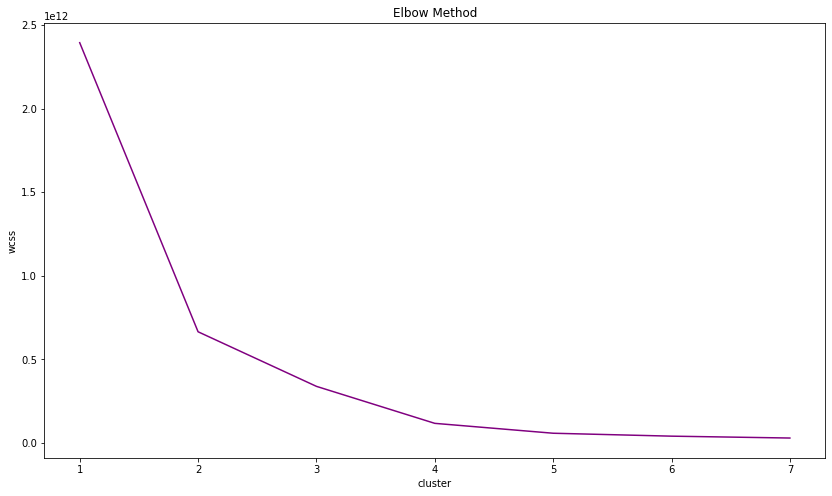

In [12]:
#Creating a df for cluster using country and count_read_user columns
df_cluster = df_model[['user_id', 'count_read_user', 'Country']]
df_cluster = df_cluster.set_index('user_id')

#Elbow method to find the optimal number of clusters
wcss = []
for i in range(1,8):                                 
    kmeans = KMeans(n_clusters=i, init = "k-means++") 
    kmeans.fit(df_cluster)
    wcss.append(kmeans.inertia_)
print (wcss)  

#Plotting elbow method
plt.figure(figsize=(14,8))
plt.plot(range(1,8),wcss, c='purple')
plt.xlabel("cluster")
plt.ylabel("wcss")
plt.title('Elbow Method')
plt.show()

In [13]:
#Building kmeans
k = 4 #Best number of cluster (see above)
kmeans = KMeans(n_clusters=k).fit(df_cluster)

#Making a new column on our df with the cluster number
df_model['cluster'] = kmeans.labels_
df_model['cluster'] = df_model['cluster'].replace(0, 4) #Changing cluster 0 to 4 so we don't have problems further on
df_model.sort_values('user_id').head(13)

,isbn,book_title,book_author,year_of_publication,publisher,user_id,rating,count_read_user,Country,cluster
0,195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,2,0,1,226,4
16,1575663937,More Cunning Than Man: A Social History of Rat...,Robert Hendrickson,1999,Kensington Publishing Corp.,8,6,17,36,4
15,1567407781,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman,1998,Brilliance Audio - Trade,8,6,17,36,4
14,1558746218,A Second Chicken Soup for the Woman's Soul (Ch...,Jack Canfield,1998,Health Communications,8,0,17,36,4
13,1552041778,Jane Doe,R. J. Kaiser,1999,Mira Books,8,5,17,36,4
12,887841740,The Middle Stories,Sheila Heti,2004,House of Anansi Press,8,5,17,36,4
11,080652121X,Hitler's Secret Bankers: The Myth of Swiss Neu...,Adam Lebor,2000,Citadel Press,8,0,17,36,4
10,771074670,Nights Below Station Street,David Adams Richards,1988,Emblem Editions,8,0,17,36,4
9,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner,8,5,17,36,4
17,1881320189,Goodbye to the Buttermilk Sky,Julia Oliver,1994,River City Pub,8,7,17,36,4


We can note that there are multiple lines for the same book, one for each user_id. Let's create a new column, taking the average of all ratings that are greater than 0 from the same book so we can have a better rating system.

In [14]:
#Transforming our rating column to float
df_model['rating'] = df_model['rating'].astype(float)

#Creating a new column by the mean of all other scores to that book
df_model['rating_mean'] = df_model[df_concat.rating > 0].groupby('book_title')['rating']\
                            .transform(lambda x: x.mean())

#Filling NA for all the books that has a Score different than 0
df_model['rating_mean'] = df_model.groupby('book_title')['rating_mean']\
                            .transform(lambda x: x.fillna(method='ffill'))

    
#Filling books that doesn't have any score with 0
df_model['rating_mean'] = df_model['rating_mean'].fillna(0)

#Printing results
df_model = df_model.sort_values(by=['book_title'])
df_model.head(10)

,isbn,book_title,book_author,year_of_publication,publisher,user_id,rating,count_read_user,Country,cluster,rating_mean
48895,590567330,A Light in the Storm: The Civil War Diary of ...,Karen Hesse,1999,Hyperion Books for Children,35859,0.0,5646,226,1,0.0
527754,590567330,A Light in the Storm: The Civil War Diary of ...,Karen Hesse,1999,Hyperion Books for Children,96448,9.0,304,226,4,9.0
216478,590567330,A Light in the Storm: The Civil War Diary of ...,Karen Hesse,1999,Hyperion Books for Children,55927,0.0,187,226,4,0.0
711574,590567330,A Light in the Storm: The Civil War Diary of ...,Karen Hesse,1999,Hyperion Books for Children,18995,0.0,81,226,4,9.0
101754,964147726,Always Have Popsicles,Rebecca Harvin,1994,Rebecca L. Harvin,172742,0.0,1685,226,2,0.0
110254,942320093,Apple Magic (The Collector's series),Martina Boudreau,1984,Amer Cooking Guild,198711,0.0,6456,226,1,0.0
386994,962295701,Beyond IBM: Leadership Marketing and Finance ...,Lou Mobley,1989,"Teleonet, Incorporated",11601,0.0,1538,226,2,0.0
116218,439188970,Clifford Visita El Hospital (Clifford El Gran...,Norman Bridwell,2000,Scholastic,216683,0.0,398,226,4,0.0
458943,399151788,Dark Justice,Jack Higgins,2004,Putnam Publishing Group,98391,10.0,5777,226,1,10.0
286350,786000015,Deceived,Carla Simpson,1994,Pinnacle Books,170595,0.0,132,226,4,0.0


**Popularity column:**

We can create a column counting how many times each book was read by a user, then we can classify this column by its %.

In [15]:
df_model['count_read'] = df_model.groupby('book_title')['book_title']\
                                                    .transform(lambda x: len(x))
    
#Printing results
df_model = df_model.sort_values(by=['book_title'])
df_model.head(7)

,isbn,book_title,book_author,year_of_publication,publisher,user_id,rating,count_read_user,Country,cluster,rating_mean,count_read
48895,590567330,A Light in the Storm: The Civil War Diary of ...,Karen Hesse,1999,Hyperion Books for Children,35859,0.0,5646,226,1,0.0,4
527754,590567330,A Light in the Storm: The Civil War Diary of ...,Karen Hesse,1999,Hyperion Books for Children,96448,9.0,304,226,4,9.0,4
216478,590567330,A Light in the Storm: The Civil War Diary of ...,Karen Hesse,1999,Hyperion Books for Children,55927,0.0,187,226,4,0.0,4
711574,590567330,A Light in the Storm: The Civil War Diary of ...,Karen Hesse,1999,Hyperion Books for Children,18995,0.0,81,226,4,9.0,4
101754,964147726,Always Have Popsicles,Rebecca Harvin,1994,Rebecca L. Harvin,172742,0.0,1685,226,2,0.0,1
110254,942320093,Apple Magic (The Collector's series),Martina Boudreau,1984,Amer Cooking Guild,198711,0.0,6456,226,1,0.0,1
386994,962295701,Beyond IBM: Leadership Marketing and Finance ...,Lou Mobley,1989,"Teleonet, Incorporated",11601,0.0,1538,226,2,0.0,1


Okay, now that we already created a field counting how many times each book appears, let's label this column by votes:
* 5- Very popular: 95%+
* 4- Pretty popular: 81%-94%
* 3- Popular: 51%-80%
* 2- Not so popular: 25%-50%
* 1- Not popular: 0%-25%

As we have these both columns, we can also create the overall score column multiplying the **count_read_category** by the **rating_mean**.

In [16]:
#Using qcut to categorize our column
df_model['count_read_category'] = pd.qcut(df_model['count_read'], q=[0.1, .25, .5, .80, .95, 1], 
                                          labels=[1,2,3,4,5])

#Changing column type from category to int
df_model['count_read_category'] = df_model['count_read_category'].astype(int)

### Overall column ###
df_model['overall_score'] = df_model['count_read_category'] * df_model['rating_mean']

#Printing results
df_model.head()

,isbn,book_title,book_author,year_of_publication,publisher,user_id,rating,count_read_user,Country,cluster,rating_mean,count_read,count_read_category,overall_score
48895,590567330,A Light in the Storm: The Civil War Diary of ...,Karen Hesse,1999,Hyperion Books for Children,35859,0.0,5646,226,1,0.0,4,2,0.0
527754,590567330,A Light in the Storm: The Civil War Diary of ...,Karen Hesse,1999,Hyperion Books for Children,96448,9.0,304,226,4,9.0,4,2,18.0
216478,590567330,A Light in the Storm: The Civil War Diary of ...,Karen Hesse,1999,Hyperion Books for Children,55927,0.0,187,226,4,0.0,4,2,0.0
711574,590567330,A Light in the Storm: The Civil War Diary of ...,Karen Hesse,1999,Hyperion Books for Children,18995,0.0,81,226,4,9.0,4,2,18.0
101754,964147726,Always Have Popsicles,Rebecca Harvin,1994,Rebecca L. Harvin,172742,0.0,1685,226,2,0.0,1,1,0.0


In [17]:
#Drop all the other columns that we used to make this last one
df_model = df_model.drop(['count_read_category', 'count_read', 'rating_mean'], axis=1)

Let's take a look into **year_of_publication** column:

In [18]:
df_model['year_of_publication'].unique()

array(['1999', '1994', '1984', '1989', '2000', '2004', '1991', '2002',
       '1996', '1995', '2001', '1998', '1997', 2004, '1973', '1990',
       '1987', '2003', '1979', '1993', '1980', '1986', '1992', 0, '1983',
       '1972', 2000, 1988, '1985', '1966', '1953', '1978', 1951, '0',
       2001, '1976', '1982', '1988', 1992, '1971', '1974', 1990, '1981',
       '1965', 1994, '1959', '1977', 2002, 1996, 2003, 1997, 1991, 1982,
       1999, 1983, '1975', '1963', '1968', 1995, 1979, '1969', 1989, 1998,
       1993, 1981, '1955', '1957', 1972, 1985, 1987, 1977, '1970', 1984,
       '1962', '1961', '1958', '1964', 1986, '1911', '1967', '1935',
       '1954', '1939', 1964, 1974, 1980, '2011', 1976, 1975, '1947',
       '1960', '1951', '2005', 1969, 1973, 1963, '1944', 1978, '1956',
       1920, '1920', '1946', '2050', '1929', 1970, '1936', '1945', '2008',
       1961, 'Bart Rulon', '1940', '1901', 1971, '1949', '1928', '1952',
       '1931', '1930', '1942', '1909', 1956, 'Stan Berenstain', '

This column is really messy, so it's better that we leave it out. 

In [19]:
df_model = df_model.drop('year_of_publication', axis=1)

We have done a great job cleaning our data, now we can create our recommender systems.

## Model Building

**Book-based recommender:**

We must create a recommender system that gives recommendation based on the behavior of similar use. To do this, first we need to identify we have historical data from the user. If the user has already rated some books, it's easy to find similar books to those that the user most liked and suggest to him. If we don't have data from the user, this method wouldn't work. Instead, we would suggest books based on personal information about the user, which we used to cluster before.

So to it wrap it up, we'll have two recommender system:

- 1: For users that has read more than 100 books:

We'll see which books that the user has most liked, find correlated books to it, and suggest top 10 back to the user.


 - 2: For users that has read less than 100 books.
 
A pretty dumb recommender. We'll use our clusters to divide our users into diferrent blocks. By doing this, we can find which books this cluster liked more and can suggest it back to the user.

*Note: To ensure statistical significance,  books with less than 100 ratings are excluded from our suggestions.*

**RECOMMENDER Nº 1: (100+ BOOKS)**

In [102]:
#Value count for users and books (could have used column count_read_user)
count_books = df_model['isbn'].value_counts()

#Filtering and creating a new df
final_df = df_model[df_model['count_read_user'] >= 100]
final_df = final_df[final_df['isbn'].isin(count_books[count_books >= 100].index)]


#Printing results
print(final_df.shape)
final_df.head()

(53075, 10)


,isbn,book_title,book_author,publisher,user_id,rating,count_read_user,Country,cluster,overall_score
421358,451524934,1984,George Orwell,Signet Book,147141,0.0,264,226,4,34.748092
254009,451524934,1984,George Orwell,Signet Book,112765,0.0,115,226,4,34.748092
533336,451524934,1984,George Orwell,Signet Book,245295,10.0,106,126,4,34.748092
595110,451524934,1984,George Orwell,Signet Book,55490,10.0,339,226,4,34.748092
202243,451524934,1984,George Orwell,Signet Book,37712,0.0,467,226,4,34.748092


In [103]:
rating_pb = final_df.pivot_table(index='user_id', columns='isbn', values='rating')
rating_pb = rating_pb.fillna(0)

print(rating_pb.shape)
rating_pb.head()

(1473, 616)


isbn,002542730X,006016848X,006099486X,006101351X,014023313X,014025448X,014028009X,014029628X,014100018X,031242227X,...,812511816,812550706,842329129,842329218,842329242,842329250,842342702,871136791,971880107,99771519
user_id,,,,,,,,,,,,,,,,,,,,,
254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
1435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0


Let's also make a new df using ISBN column as index and taking just the columns overall_score and book_title from final_df

In [104]:
overall = final_df.drop_duplicates('isbn')
overall = overall.set_index('isbn')
overall = overall[['overall_score', 'book_title']]
overall

,overall_score,book_title
isbn,,
451524934,34.748092,1984
446610038,38.493151,1st to Die: A Novel
316666009,38.493151,1st to Die: A Novel
316693200,38.848921,2nd Chance
446612790,38.848921,2nd Chance
...,...,...
425143325,31.701493,Without Remorse
142001430,33.200000,Year of Wonders
671004549,30.090909,You Belong To Me


In [105]:
overall.describe()

,overall_score
count,616.000000
mean,31.877025
std,6.671784
min,0.000000
25%,29.953106
50%,31.558600
75%,34.425710
max,45.488889


Now we can find correlated books. Let's find a correlated book to our first book (000104687X):

In [106]:
#Our first book
first_book = rating_pb['002542730X']

#Calculating correlation and making df
corr = rating_pb.corrwith(first_book)
corr_df = pd.DataFrame(corr, columns=['Correlation']).dropna().sort_values('Correlation', ascending=False)
corr_df = corr_df.join(overall)


#Printing results that overall_score > 75%
corr_df[corr_df['overall_score'] >= 34.426].head()

,Correlation,overall_score,book_title
isbn,,,
080411109X,0.143465,39.051724,The Hundred Secret Senses
552998486,0.106344,39.592593,Chocolat
055321313X,0.104422,35.500000,Anne of Green Gables (Anne of Green Gables Nov...
440224675,0.098353,36.030303,Hannibal
316666009,0.094758,38.493151,1st to Die: A Novel


To build our model we will pick a user, find which books he liked the most and suggest correlationated books to this user.

In [107]:
from pandas.core.common import flatten
def recommender(user_id):
    
    #Creating our lists for final results
    list_suggestions = []
    
    #Loc current user
    current_user = rating_pb.index.get_loc(user_id)
    
    #Find top 3 rated books from this user
    top5 = rating_pb.iloc[current_user, :].sort_values(ascending=False)
    books = list(top5[:5].index)
    
    #Finding correlated books 
    for i in books:
        corr = rating_pb.corrwith(rating_pb[i]).sort_values(ascending=False)
        corr_df = pda.DataFrame(corr, columns=['Correlation']).dropna().sort_values('Correlation', ascending=False)
        corr_df = corr_df.join(overall)
        corr_df = corr_df[corr_df['overall_score'] >= 34.426]
        suggestions = list(corr_df[0:5].book_title)
        list_suggestions.append(suggestions)
    
      
    #Let's remove all books from suggestion that the user has already read
    already_read = list(top5.index)
    
    for i in already_read:
        if i in list_suggestions:
            list_suggestions.remove(i)
    
    #Let's create a top 10 suggestion for the user
    list_suggestions = list(flatten(list_suggestions))
    final_suggestions = pd.Series(list_suggestions).drop_duplicates().to_list()
    final_suggestions = final_suggestions[0:10]
            
    return final_suggestions

In [108]:
recommender(2276)

['2nd Chance',
 '1st to Die: A Novel',
 'The Last Precinct',
 'The Beach House',
 'Violets Are Blue',
 'The Runaway Jury',
 'The Testament',
 'The Chamber',
 'The Rainmaker',
 'The Pelican Brief']

Our recommender Nº 1 is ready, now we just need to make our recommender for users that has read less than 100 books.

**RECOMMENDER Nº 2: (0 - 99 BOOKS)**

In [109]:
#Value count for users and books (could have used column count_read_user)
count_books = df_model['isbn'].value_counts()

#Filtering and creating a new df
final_df2 = df_model[df_model['count_read_user'] < 99]
final_df2 = final_df2[final_df2['isbn'].isin(count_books[count_books >= 100].index)]


#Printing results
print(final_df2.shape)
final_df2.head()

(60514, 10)


,isbn,book_title,book_author,publisher,user_id,rating,count_read_user,Country,cluster,overall_score
580466,451524934,1984,George Orwell,Signet Book,237426,0.0,8,226,4,34.748092
797816,451524934,1984,George Orwell,Signet Book,15583,0.0,3,226,4,34.748092
594499,451524934,1984,George Orwell,Signet Book,117450,0.0,24,226,4,34.748092
797873,451524934,1984,George Orwell,Signet Book,193248,10.0,40,226,4,34.748092
590505,451524934,1984,George Orwell,Signet Book,52987,7.0,6,226,4,34.748092


In [112]:
unique_cluster = final_df2['cluster'].unique()
unique_cluster

array([4])

All users that has read less than 99 books are all from cluster number 4. This is cool since it'll make things easier to us. Let's make the column overall_score again just using the ratings from this users and build a simple recommender. 

In [129]:
#Creating a new column by the mean of all other scores to that book
final_df2['rating_mean'] = final_df2[final_df2.rating > 0].groupby('book_title')['rating']\
                            .transform(lambda x: x.mean())
#Filling NA for all the books that has a Score different than 0
final_df2['rating_mean'] = final_df2.groupby('book_title')['rating_mean']\
                            .transform(lambda x: x.fillna(method='bfill'))
#Filling books that doesn't have any score with 0
final_df2['rating_mean'] = final_df2['rating_mean'].fillna(0) 

######## Count read column #########
final_df2['count_read'] = final_df2.groupby('book_title')['book_title']\
                                                    .transform(lambda x: len(x))


#Using qcut to categorize our column
final_df2['count_read_category'] = pd.qcut(final_df2['count_read'], q=[0.1, .25, .5, .80, .95, 1], 
                                          labels=[1,2,3,4,5])
#Changing column type from category to int

final_df2['count_read_category'] = final_df2['count_read_category'].fillna(1).astype(int)

### Overall column ###
final_df2['overall_score'] = final_df2['count_read_category'] * final_df2['rating_mean']
final_df2.head()

,isbn,book_title,book_author,publisher,user_id,rating,count_read_user,Country,cluster,overall_score,rating_mean,count_read,count_read_category
580466,451524934,1984,George Orwell,Signet Book,237426,0.0,8,226,4,17.258065,8.629032,104,2
797816,451524934,1984,George Orwell,Signet Book,15583,0.0,3,226,4,17.258065,8.629032,104,2
594499,451524934,1984,George Orwell,Signet Book,117450,0.0,24,226,4,17.258065,8.629032,104,2
797873,451524934,1984,George Orwell,Signet Book,193248,10.0,40,226,4,17.258065,8.629032,104,2
590505,451524934,1984,George Orwell,Signet Book,52987,7.0,6,226,4,17.258065,8.629032,104,2


All we have to do to make this recommender is drop all the columns that we aren't going to use and sort values by the overall_score and a new rating_pivot_table. After this, we just need to remove all the books that the user has already read.

In [139]:
recommender = final_df2.drop(['isbn', 'publisher', 'user_id', 'rating', 'count_read_user', 'count_read',
                              'Country', 'cluster', 'rating_mean', 'count_read_category'], axis=1)

recommender = recommender.drop_duplicates('book_title').set_index('book_title')\
                         .sort_values('overall_score', ascending=False)

recommender.head()

,isbn,book_author,user_id,overall_score
book_title,,,,
The Lovely Bones: A Novel,316666343,Alice Sebold,242914,40.683230
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),059035342X,J. K. Rowling,186242,35.583333
Harry Potter and the Chamber of Secrets (Book 2),439064864,J. K. Rowling,29413,35.353293
The Secret Life of Bees,142001740,Sue Monk Kidd,124983,33.653846
The Da Vinci Code,385504209,Dan Brown,89711,33.427729


In [148]:
rating_pb2 = final_df2.pivot_table(index='user_id', columns='isbn', values='rating')
rating_pb2 = rating_pb.fillna(0)

print(rating_pb2.shape)
rating_pb2.head()

(26403, 616)


isbn,002542730X,006016848X,006099486X,006101351X,014023313X,014025448X,014028009X,014029628X,014100018X,031242227X,...,812511816,812550706,842329129,842329218,842329242,842329250,842342702,871136791,971880107,99771519
user_id,,,,,,,,,,,,,,,,,,,,,
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [163]:
def simple_recommender(user_id):
    
    #Creating our lists for final results
    list_suggestions = []
    
    #Loc current user
    current_user = rating_pb.index.get_loc(user_id)
    
    #Find all the books that the user has read
    all_books_user = list(rating_pb2.iloc[current_user, :].index)
    
    #List of top rated books
    list_top_books = list(recommender.index)
    
    #Removing the books that the user has already read from the top rated list
    for i in all_books_user:
        if i in list_top_books:
            list_top_books.remove(i)
    
    #Returning top 10 books
    return list_top_books[0:10]

In [164]:
simple_recommender(9)

['The Lovely Bones: A Novel',
 "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))",
 'Harry Potter and the Chamber of Secrets (Book 2)',
 'The Secret Life of Bees',
 'The Da Vinci Code',
 'The Poisonwood Bible: A Novel',
 'The Joy Luck Club',
 'Angels &amp; Demons',
 'The Red Tent (Bestselling Backlist)',
 'Life of Pi']

All users can have recommendations of books. This project helped me learn about recommendation systems and how they work. It was a cool experience because it's pretty different than most Data Science problems where you use ML to answer most of the questions. 

To improve these recommenders, it would be nice if we had genres for the books and the age column without so many strange values.